In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Week-2



## Dataset

Run the cell given below to generate the data-matrix $\mathbf{X}$, which is of shape $(n, d)$, where $n$ denotes the number of samples and $d$ denotes the number of features. Ignore the vector $y$. You will be using this dataset for the rest of the assignment. Do not edit this cell.

In [10]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, factor=0.9, noise=0.2, random_state=0)

## Problem 1
Plot the dataset using matplotlib.

In this , X[:,0] is the feature - x coordinate , and X[:,1] is the feature - y coordinate , and there are 1000 such samples

every sample is just a point on the coordinate graph , all of them together makes an approimate circle, if we
 remove noise in the above given code cell , the circle becomes more circle like , if the noise is 0 , it becomes exacty a circle

Also in actuallity , there are two circles , if a circle a has radius x , then the other circle has the radius factor*x , where 
factor is mentioned in the make circle parameter.

## solution

(1000, 2)


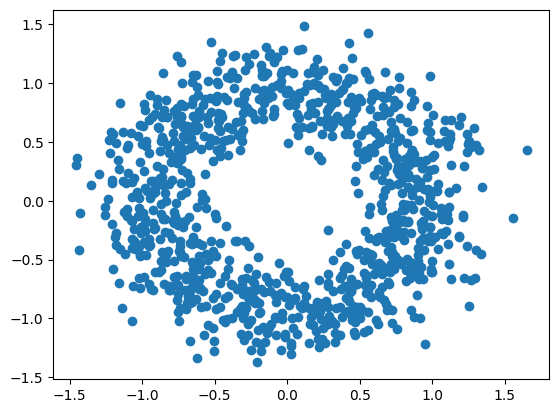

In [11]:
plt.scatter(X[:, 0], X[:, 1])
print(X.shape) # should come out as 1000,2

## Problem 2
How many samples,features are there in the dataset?


## solution

In [13]:
print(X.shape[0])
print(X.shape[1])

1000
2


## Problem 4
Find the kernel matrix $K$ using the polynomial kernel with degree $2$. 


A Kernel matrix is a matrix , where K<sub>ij</sub> represents the similarity between those datapoints + some constant , which in this case is 1.
As we can see we have done X.dot(X.T) + (1) , we add this one to every element

we raise the power of each element to the given degree of polynomial kernel, which in this case is 2 , for example if K<sub>11</sub> = 2 and the degree is 2 , we replace it with 4.

if the degree was 3 , we would cube it.

For lower dimension , X<sub>ij</sub> might approach 0 , so we add a constant to it to make it more flexible.

There are any types of kernel , different types of kernel have different type of formula.

In [73]:
def PolyKernel(X, p):
  return (X.dot(X.T)+1)**p

K = PolyKernel(X, 2)

assert(np.array_equal(K,K.T))


## Problem 5
Find the kernel matrix $K$ using the Gaussian kernel with parameter $\sigma = 2$. 

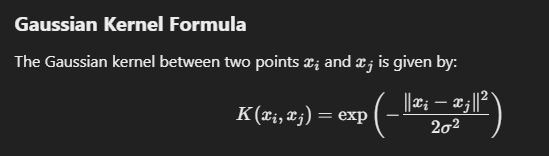

where $\sigma$ is the given parameter

so we have to iterate to get every possible combination of i and j.

In this case , i believe that we can half the time , by calculating for lower traingle and replicating it to upper traingle , since it is taking 8.3 seconds as of now :/

Well , if i calculate for the half and replicate it , it takes 6.1 seconds , which is quite an improvement as comparent to 8.3 seconds , it seems that CP is useful afterall :) .

In [40]:

def Gkernel(x, y, s):
  return np.exp((-np.linalg.norm((x-y))**2)/(2*(s**2)))

def RBFKernel(X, sigma):
  n = X.shape[0]
  return np.array([Gkernel(X[i], X[j], sigma) for i in range(X.shape[0]) for j in range(X.shape[0])]).reshape(n, n)

dp = {}
def Gkernel1(i,j,x, y, s):
  k,k1 = min(i,j),max(i,j)
  if (k,k1) in dp:
    return dp[(k,k1)]
  dp[(k,k1)] = np.exp((-np.linalg.norm((x-y))**2)/(2*(s**2)))
  return dp[(k,k1)]

def RBFKernel1(X, sigma):
  n = X.shape[0]
  return np.array([Gkernel1(i,j,X[i], X[j], sigma) for i in range(X.shape[0]) for j in range(X.shape[0])]).reshape(n, n)

In [94]:
K1 = RBFKernel1(X, 2)
K = RBFKernel(X,2)
assert (np.array_equal(K,K1))

## Problem 6
Find the center of the kernel matrix $K$ obtained in problem 4. Call this centered matrix $KC$.

In this centering , we aren't centering the way we normally do, we are first substracting the row mean from the row , then substracting the column mean from the column , then adding the overall mean to the whole matrix , for doing that , we are first substracting K.mean(axis=0), this will give a 1 by n matrix where each element is the average of the column and then we substract it from each row of the orignal matrix.

K.mean(axis=1) : this returns a 1 by n matrix , but since we need a n by 1 matrix , we do keepdims = True , then we substract this from every column thus cenetring the feature as well , since we are now substracting two times , we add the overall mean which is K.mean() , which is just a number to each element.

The K_centered function is the harder way of doing it, like K.dot(one_n) returns the row mean and then we substract it from every element.

Also just asserting .all() is equal does not work , i need to do np.array_euqla(KC,KC1) , .all() just checks if both are either zero or non zero , it does not compare the values.

I think the K_centered functions gives a more accurate value, since the difference in between there values when added up is round 10**-10.

In general , what i have noticed , the rows are the data points and the columns are the features , except sometimes , when they take the transpose , idk why :/

## solution

In [104]:
def K_centered(K):
  N = K.shape[0]
  one_n = np.ones((N,N)) / N
  K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
  return K

# def K_centered_easier(K):
#   return K-K.mean(axis=0)   
#this function only ceters each point, not the feature , therefore it gives quite a different answer then the other two centering

def K_centered_harder(K):
  return K-K.mean(axis=0)-K.mean(axis=1,keepdims=True) + K.mean()

In [108]:
KC = K_centered(K)
KC1 = K_centered_harder(K)
# print(KC)
# print(KC1)
difference = 0
for i in range(len(KC)):
    for j in range(len(KC[0])):
        difference += abs(KC[i][j]-KC1[i][j])
 
assert(difference<=10**(-9))


## Problem 7
Find the projections (scalar) of all the data points on to the first two principal components obtained using polynomial kernel of degree 2.

First we calculate the first and second PCA, which is eigvec[:,-1] and eigvec[:,-2] , we also get the corresponding eigen vector.

Then we calculate alpha of both the component , which is equal to 

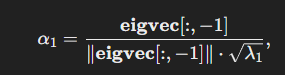  i will have to remember this formula , it is quite logical tbh 

since we are dividing the eigen vector by its mod , it becomes the direction of the eigen vector , and then we divide it by root of its eigen value to make it standardized.
This alpha that we find thus is the direction vector.

Which is then used to determine the scalar projection by doing its dot product with the orignal matrix which in this case is M. Therefore our final projection is alpha1 @ M for the first eigen vector (the first direction) and alpha2 @ M for the second eigen vector (the second direction).

## solution

In [ ]:
def Projection(M):
    eigval, eigvec = np.linalg.eigh(M)
    lambda_1, lambda_2 = eigval[-1], eigval[-2]
    alpha_1, alpha_2 = eigvec[:, -1]/ (np.linalg.norm(eigvec[:, -1])*np.sqrt(lambda_1)), eigvec[:, -2]/(np.linalg.norm(eigvec[:, -2])*np.sqrt(lambda_2))
    return alpha_1.dot(M), alpha_2.dot(M)
    #return eigvec[:, -1], eigvec[-2]


In [ ]:
pc1, pc2 = Projection(KC)